# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

In [103]:
# import libraries
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import desc, floor, first, row_number, asc, sum as Fsum, max as Fmax, avg, udf, isnan, count, col, when

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from sklearn.metrics import f1_score, accuracy_score


In [104]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. 

In [105]:
sparkify_data_path = 'mini_sparkify_event_data.json'

df = spark.read.json(sparkify_data_path)

In [106]:
df.where(df.userId=="").show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [107]:
#Drop any rows that have a missing userId or sessionId, either with Nan value or empty string. 
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df = df.filter(df.userId != "")

In [108]:
df.select(["userID"]).dropDuplicates().describe().show()
df.count()


+-------+------------------+
|summary|            userID|
+-------+------------------+
|  count|               225|
|   mean|65391.013333333336|
| stddev|105396.47791907164|
|    min|                10|
|    max|                99|
+-------+------------------+



278154

The cleaned data set contains 278,154 rows, and 225 unique customers. 

# Exploratory Data Analysis

### Define Churn

Create a column `Churn` to use as the label for your model. I have used the `Cancellation Confirmation` events to define churn, which happen for both paid and free users.

### Explore Data

In [109]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [110]:
df.where(df.userId==30).show(5)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|  Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|Bakersfield, CA|   PUT|       NextSong|1538173362000| 

In [111]:
df.select("page").dropDuplicates().show()
df.select("level").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [112]:
#Looking at a customer journey in the data set. 
df.where(df.userId==30).select(["status","level","page"]).show(30)

+------+-----+---------------+
|status|level|           page|
+------+-----+---------------+
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|Add to Playlist|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   307| paid|    Thumbs Down|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   200| paid|       NextSong|
|   307| paid|      Thumbs Up|
|   200| paid|       NextSong|
|   307|

In [113]:
#Creating Churn column. flag_cancelled_event is used to add a binary column marking any cancellation event, 
#while the window function is used to group by userId and add a customer level column, which is the same for
#every row sharing the same userId

flag_cancelled_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
windowval1 = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df = df.withColumn("Cancelled", flag_cancelled_event("page"))
df = df.withColumn("Churn", Fmax("Cancelled").over(windowval1))

In [114]:
df.select("userId","Churn").dropDuplicates().show(10)



+------+-----+
|userId|Churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [115]:
df_NoDowngrade = df.where(df.Churn == 0)
df_Downgrade = df.where(df.Churn ==1)

In [116]:
numCancelledCusts = df_Downgrade.select("userId").dropDuplicates().count()
numNonCancelledCusts = df_NoDowngrade.select("userId").dropDuplicates().count()

print("Number of cancelled customers: ", numCancelledCusts)
print("Number of non cancelled customers: ", numNonCancelledCusts)

Number of cancelled customers:  52
Number of non cancelled customers:  173


Analyse the frequency of each page type in cancelled and non-cancelled users

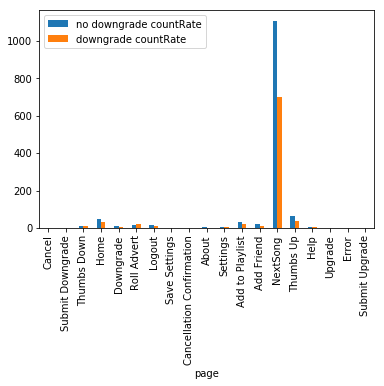

In [117]:
df_NoDowngrade_counts = df_NoDowngrade.groupby("page").count()
df_NoDowngrade_countsRate= df_NoDowngrade_counts.\
    withColumn("no downgrade countRate",df_NoDowngrade_counts["count"]/numNonCancelledCusts)

df_Downgrade_counts = df_Downgrade.groupby("page").count()
df_Downgrade_countsRate= df_Downgrade_counts.withColumn("downgrade countRate",df_Downgrade_counts["count"]/numCancelledCusts)

pandas_for_chart = df_NoDowngrade_countsRate.join(df_Downgrade_countsRate, "page", "outer").drop("count").toPandas().fillna(0)
pandas_for_chart.plot.bar("page")

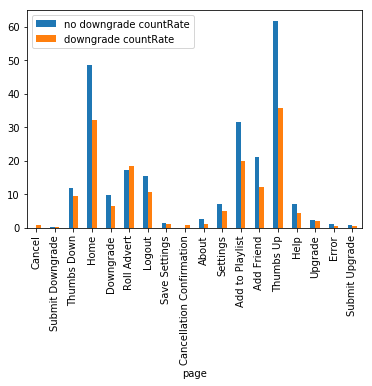

In [118]:
#Replicate the above chart without the NextSong column
df_NoDowngrade_countsNoSong = df_NoDowngrade.filter(df_NoDowngrade["page"] != "NextSong").groupby("page").count()
df_NoDowngrade_countsRateNoSong= df_NoDowngrade_countsNoSong.withColumn("no downgrade countRate",df_NoDowngrade_countsNoSong["count"]/numNonCancelledCusts)

df_Downgrade_countsNoSong = df_Downgrade.filter(df_Downgrade.page != "NextSong").groupby("page").count()
df_Downgrade_countsRateNoSong= df_Downgrade_countsNoSong.withColumn("downgrade countRate",df_Downgrade_countsNoSong["count"]/numCancelledCusts)

pandas_for_chart2 = df_NoDowngrade_countsRateNoSong.join(df_Downgrade_countsRateNoSong, "page", "outer").drop("count").toPandas().fillna(0)
pandas_for_chart2.plot.bar("page")

Pages of note are Home, Thumbs Up, Add Friend, and Add to Playlist. 

Customers who didn't cancel tended to play more songs than those who didn't cancel. 

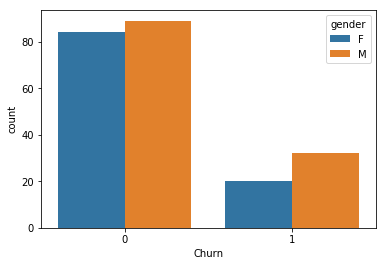

In [119]:
df_gender = df.select(["userId","gender","Churn"]).dropDuplicates().toPandas()
#df_gender = df_gender.withColumn(gender_rate)
ax = sns.countplot(x = "Churn", hue = "gender", data = df_gender)

There is a bigger difference in gender counts in the set of cancelled customers than in the customers who didn't cancel. 

#### Feature Engineering

The following customer level features will now be created:

 - Number of songs played in 1, 2, 3, and 4 weeks leading up to the customer's final activity in the data
 - Number of 'Home' views in 1, 2, 3, and 4 weeks leading up to the customer's final activity in the data
 - Number of 'Thumbs Up' actions in 1, 2, 3, and 4 weeks leading up to the customer's final activity in the data
 - Number of 'Add Friend' actions in 1, 2, 3, and 4 weeks leading up to the customer's final activity in the data
 - Number of songs 'Added to Playlist' actions in 1, 2, 3, and 4 weeks leading up to the customer's final activity in the data
 - The proportional increase in number of songs played from the fortnight before the last fortnight of data, and the last    fortnight of data
 - Whether the customer was a paid or free member at their last activity in the dataset
 - The average length of session a customer has
 

In [120]:
#The UDF functions flag each page event of interest in a separate column. 
#The window function then sums these columns to get to total count for each userId.

flag_nextSong_event = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
df = df.withColumn("NextSong", flag_nextSong_event("page"))

flag_Home_event = udf(lambda x: 1 if x == "Home" else 0, IntegerType())
df = df.withColumn("Home", flag_Home_event("page"))

flag_ThumbsUp_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
df = df.withColumn("ThumbsUp", flag_ThumbsUp_event("page"))

flag_AddFriend_event = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
df = df.withColumn("AddFriend", flag_AddFriend_event("page"))

flag_AddPlaylist_event = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
df = df.withColumn("AddPlaylist", flag_AddPlaylist_event("page"))

#This is the same WindowVal as previously used in the notebook
windowval_1 = Window.partitionBy("userId").orderBy(asc("ts"))\
                    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("songCount", Fsum("NextSong").over(windowval1))
df = df.withColumn("homeCount", Fsum("Home").over(windowval1))
df = df.withColumn("thumbsUpCount", Fsum("ThumbsUp").over(windowval1))
df = df.withColumn("addFriendCount", Fsum("AddFriend").over(windowval1))
df = df.withColumn("addPlaylistCount", Fsum("AddPlaylist").over(windowval1))

In [121]:
df = df.withColumn("MaxTime", Fmax("ts").over(windowval1))
df = df.withColumn("TimeFromEnd", df.MaxTime - df.ts)

In [122]:
#Weeks from end is specific for each userId, and is the number of weeks before the userId's last activity. 

flag_week = udf(lambda x: x/604800000)
df  = df.withColumn("WeeksFromEnd", flag_week("TimeFromEnd"))
df = df.withColumn("WeeksFromEndInt",floor(df.WeeksFromEnd))

In [123]:
#Create a column which is grouped by userId and the week (defined as weeks before the last user activity)
#providing a sum of each page activity of interest in that particular week. 

windowval2 = Window.partitionBy(["userId", "WeeksFromEndInt"]).orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df = df.withColumn("songs_in_week", Fsum("NextSong").over(windowval2))
df = df.withColumn("home_in_week", Fsum("Home").over(windowval2))
df = df.withColumn("thumbsUp_in_week", Fsum("ThumbsUp").over(windowval2))
df = df.withColumn("addFriends_in_week", Fsum("AddFriend").over(windowval2))
df = df.withColumn("addPlaylist_in_week", Fsum("AddPlaylist").over(windowval2))

In [124]:
df.show(25)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+-----+--------+----+--------+---------+-----------+---------+---------+-------------+--------------+----------------+-------------+-----------+--------------------+---------------+-------------+------------+----------------+------------------+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Cancelled|Churn|NextSong|Home|ThumbsUp|AddFriend|AddPlaylist|songCount|homeCount|thumbsUpCount|addFriendCount|addPlaylistCount|      MaxTime|TimeFromEnd|        WeeksFromEnd|WeeksFromEndInt|songs_in_week|home_in_week|thumbsUp_in_week|addFriends_in_week|addPlaylist_in_week|


In [125]:
windowval3 = Window.partitionBy("userId","sessionId").orderBy(desc("ts"))\
                   .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
windowval4 = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df = df.withColumn("SessionLen",Fmax("itemInSession").over(windowval3))
df_sessionLen = df.select("userId","SessionLen","sessionId").dropDuplicates()\
.withColumn("avgSessionLen",avg("SessionLen").over(windowval4)).drop("sessionId","SessionLen").dropDuplicates()
df_sessionLen.show(10)

+------+------------------+
|userId|     avgSessionLen|
+------+------------------+
|100010| 54.42857142857143|
|200002|              80.0|
|   125|              10.0|
|   124|170.13793103448276|
|    51|             251.9|
|     7|28.428571428571427|
|    15|154.86666666666667|
|    54| 94.21621621621621|
|   155|171.66666666666666|
|100014|51.833333333333336|
+------+------------------+
only showing top 10 rows



In [126]:
#Add the membership status of the customer at their last action

windowval5 = Window.partitionBy("userId").orderBy(desc("ts"))
df = df.withColumn("row_in_user_group",row_number().over(windowval5))
df_membership_status = df.select("userId","row_in_user_group","level").where(df["row_in_user_group"]==1)\
                      .drop("row_in_user_group").dropDuplicates()
df_membership_status = df_membership_status.select("userId",col("level").alias("final_level"))

In [127]:
df_drop = df.drop("artist","auth","itemInSession","length","level","location","method","page","registration","sessionId",\
                  "song","status","ts","userAgent","time","hour","weekday","day","Cancelled","NextSong","Home","ThumbsUp",\
                  "AddFriend","AddPlaylist","TimeFromEnd","SessionLen","row_in_user_group").dropDuplicates()
df_pivot = df_drop.where(df_drop.WeeksFromEndInt <=3).groupBy('userId').pivot('WeeksFromEndInt')\
                  .agg(first('songs_in_week').alias('songs_week'),first('home_in_week').alias('home_week'),\
                       first('thumbsUp_in_week').alias('thumbsUp_week'),first('addFriends_in_week')\
                       .alias('addFriends_week'),first('addPlaylist_in_week').alias('addPlaylist_week'))
#df_drop = df_drop.select("firstName","gender","lastName","userId","Churn").dropDuplicates()

In [128]:
df_base = df_drop.drop("MaxTime","WeeksFromEnd","WeeksFromEndInt","songs_in_week","home_in_week","thumbsUp_in_week",\
                       "addFriends_in_week","addPlaylist_in_week").dropDuplicates()

In [129]:
df_base.printSchema()

root
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- songCount: long (nullable = true)
 |-- homeCount: long (nullable = true)
 |-- thumbsUpCount: long (nullable = true)
 |-- addFriendCount: long (nullable = true)
 |-- addPlaylistCount: long (nullable = true)



In [130]:
#Check that each dataset contains 225 rows before joining
print(df_base.count())
print(df_pivot.count())
print(df_sessionLen.count())
print(df_membership_status.count())

225
225
225
225


In [131]:
df_pivot.select([count(when(col(c).isNull(), c)).alias(c) for c in df_pivot.columns]).show()

+------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+
|userId|0_songs_week|0_home_week|0_thumbsUp_week|0_addFriends_week|0_addPlaylist_week|1_songs_week|1_home_week|1_thumbsUp_week|1_addFriends_week|1_addPlaylist_week|2_songs_week|2_home_week|2_thumbsUp_week|2_addFriends_week|2_addPlaylist_week|3_songs_week|3_home_week|3_thumbsUp_week|3_addFriends_week|3_addPlaylist_week|
+------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+
|     0|           0|          0|    

In [132]:
#Fill null values in pivot with 0s. These are created during the pivot when there are no values for a column. 
#This means the frequency count is 0, meaning the column value should be 0. 
df_pivot = df_pivot.fillna(0)
df_join = df_base.join(df_pivot,"userId","left").join(df_sessionLen,"userId","left").\
          join(df_membership_status,"userId","left")

df_join =  df_join.withColumn("percIncreaseSong",(df_join["0_songs_week"])/\
           (df_join["0_songs_week"]+df_join["1_songs_week"]+df_join["2_songs_week"]+df_join["3_songs_week"]+1))
df_join.show(5)

+------+---------+------+---------+-----+---------+---------+-------------+--------------+----------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------------+-----------+-------------------+
|userId|firstName|gender| lastName|Churn|songCount|homeCount|thumbsUpCount|addFriendCount|addPlaylistCount|0_songs_week|0_home_week|0_thumbsUp_week|0_addFriends_week|0_addPlaylist_week|1_songs_week|1_home_week|1_thumbsUp_week|1_addFriends_week|1_addPlaylist_week|2_songs_week|2_home_week|2_thumbsUp_week|2_addFriends_week|2_addPlaylist_week|3_songs_week|3_home_week|3_thumbsUp_week|3_addFriends_week|3_addPlaylist_week|     avgSessionLen|final_level|   percIncreaseSong|
+------+---------+------+---------+-----+---------+-------

In [133]:
#Check that the number of rows in the joined dataset is 225. 
df_join.count()

225

In [134]:
#Drop unnecesarry columns, and make character variables numeric. 

df_cust_lvl = df_join.drop("MaxTime","WeeksFromEnd","weeksFromEndInt","songs_in_week","home_in_week","thumbsUp_in_week",\
                           "addFriends_in_week","addPlaylist_in_week").dropDuplicates()

updateGender = udf(lambda x:1 if x == "M" else 0,IntegerType())
updateMembershipStatus  = udf(lambda x:1 if x == "paid" else 0,IntegerType())

df_cust_lvl = df_cust_lvl.withColumn("gender",updateGender(df_cust_lvl.gender))\
.withColumn("final_level",updateMembershipStatus(df_cust_lvl.final_level))
df_cust_lvl.show(5)

+------+---------+------+---------+-----+---------+---------+-------------+--------------+----------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------------+-----------+-------------------+
|userId|firstName|gender| lastName|Churn|songCount|homeCount|thumbsUpCount|addFriendCount|addPlaylistCount|0_songs_week|0_home_week|0_thumbsUp_week|0_addFriends_week|0_addPlaylist_week|1_songs_week|1_home_week|1_thumbsUp_week|1_addFriends_week|1_addPlaylist_week|2_songs_week|2_home_week|2_thumbsUp_week|2_addFriends_week|2_addPlaylist_week|3_songs_week|3_home_week|3_thumbsUp_week|3_addFriends_week|3_addPlaylist_week|     avgSessionLen|final_level|   percIncreaseSong|
+------+---------+------+---------+-----+---------+-------

In [135]:
#Move the churn column to the end of the dataframe.
df_user_churned = df_cust_lvl.select("userId", "Churn")
df_cust_lvl_no_churn = df_cust_lvl.drop("Churn")
df_with_churn = df_cust_lvl_no_churn.join(df_user_churned, "userId", "left")

In [136]:
df_final = df_with_churn.drop("userId","firstName","lastName")

In [137]:
#Check for Nan values
df_final.select([count(when(isnan(c), c)).alias(c) for c in df_final.columns]).show()

+------+---------+---------+-------------+--------------+----------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+-------------+-----------+----------------+-----+
|gender|songCount|homeCount|thumbsUpCount|addFriendCount|addPlaylistCount|0_songs_week|0_home_week|0_thumbsUp_week|0_addFriends_week|0_addPlaylist_week|1_songs_week|1_home_week|1_thumbsUp_week|1_addFriends_week|1_addPlaylist_week|2_songs_week|2_home_week|2_thumbsUp_week|2_addFriends_week|2_addPlaylist_week|3_songs_week|3_home_week|3_thumbsUp_week|3_addFriends_week|3_addPlaylist_week|avgSessionLen|final_level|percIncreaseSong|Churn|
+------+---------+---------+-------------+--------------+----------------+------------+-----------+---------------+-------------

In [138]:
#Check or Null values
df_final.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final.columns]).show()

+------+---------+---------+-------------+--------------+----------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+-------------+-----------+----------------+-----+
|gender|songCount|homeCount|thumbsUpCount|addFriendCount|addPlaylistCount|0_songs_week|0_home_week|0_thumbsUp_week|0_addFriends_week|0_addPlaylist_week|1_songs_week|1_home_week|1_thumbsUp_week|1_addFriends_week|1_addPlaylist_week|2_songs_week|2_home_week|2_thumbsUp_week|2_addFriends_week|2_addPlaylist_week|3_songs_week|3_home_week|3_thumbsUp_week|3_addFriends_week|3_addPlaylist_week|avgSessionLen|final_level|percIncreaseSong|Churn|
+------+---------+---------+-------------+--------------+----------------+------------+-----------+---------------+-------------

In [139]:
df_final.show(5)

+------+---------+---------+-------------+--------------+----------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------+-----------+---------------+-----------------+------------------+------------------+-----------+-------------------+-----+
|gender|songCount|homeCount|thumbsUpCount|addFriendCount|addPlaylistCount|0_songs_week|0_home_week|0_thumbsUp_week|0_addFriends_week|0_addPlaylist_week|1_songs_week|1_home_week|1_thumbsUp_week|1_addFriends_week|1_addPlaylist_week|2_songs_week|2_home_week|2_thumbsUp_week|2_addFriends_week|2_addPlaylist_week|3_songs_week|3_home_week|3_thumbsUp_week|3_addFriends_week|3_addPlaylist_week|     avgSessionLen|final_level|   percIncreaseSong|Churn|
+------+---------+---------+-------------+--------------+----------------+------------+-----------+-------------

# Modeling

 Models to be built:
 - Logistic Regression
 - XG Boost
 - Random Forest
 - Decision Tree 

In [140]:
features_list = df_final.columns[:]
for feature in features_list:
    df_final = df_final.withColumn(feature, df_final[feature].cast("float"))

In [141]:
assembler = VectorAssembler(inputCols=df_final.columns[:-1], outputCol="Features")
data = assembler.transform(df_final)

scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures", withStd=True)
scaler_trans = scaler.fit(data)
data = scaler_trans.transform(data)

data = data.select(data.Churn.alias("label"), data.ScaledFeatures.alias("features"))

In [142]:
#Cross validation is being used, so no test set is needed for model development
train, validation = data.randomSplit([0.8,0.2], seed = 24)

In [143]:
def ModelScores(model, model_name):
    '''A function to provide the F1 score of any trained model.
       input: model - The trained model with which to score
              model_name (str) - A string prefix that will appear in the output
       output: f1Score - The F1 Score of the model, on the validation data set.
    '''
    predictions = model.transform(validation)
    predictions_pd = predictions.toPandas()
    f1Score = f1_score(predictions_pd.label,predictions_pd.prediction)
    accuracyScore = accuracy_score(predictions_pd.label,predictions_pd.prediction)
    print(model_name," F1 score: ",f1Score)
    print(model_name," Accuracy: ",accuracyScore)

In [144]:
def Feature_Importance_Tree(model):
    '''This function will output the features most used in a tree based model. 
       This gives a good idea of the feature importance of the model
       
    '''
    feat_imp_list = list(model.bestModel.featureImportances)
    features_list = list(df_final.drop("Churn").columns[:])

    Importance_Dict = {"Feature":features_list,"Importance_Score":feat_imp_list}
    Feature_Importance = pd.DataFrame(Importance_Dict).sort_values(by = "Importance_Score", ascending = False)

    return (Feature_Importance.head(10))

In [90]:
LogisticRegression().explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must be

In [91]:
lr = LogisticRegression()

paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0,0.1])\
                              .addGrid(lr.elasticNetParam, [0.0, 0.1])\
                              .addGrid(lr.maxIter,[10,20])\
                              .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 97) 

lr_model = crossval.fit(train)

print("Logistic regression training complete")

Logistic regression training complete


In [ ]:
lr_model.write().overwrite().save("lr_model.model")

In [ ]:
lr_model = CrossValidatorModel.load('lr_model1.model')

In [168]:
print("Best minInstancesPerNode value:", lr_model.bestModel._java_obj.getRegParam())
print("Best maxIter value:", lr_model.bestModel._java_obj.getMaxIter())
print("Best elasticNetParam value:", lr_model.bestModel._java_obj.getElasticNetParam())

Best minInstancesPerNode value: 0.1
Best maxIter value: 10
Best elasticNetParam value: 0.1


In [169]:
lr = LogisticRegression()

paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.1,0.2])\
                              .addGrid(lr.elasticNetParam, [0.1,0.2])\
                              .addGrid(lr.maxIter,[10])\
                              .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 97) 

lr_model = crossval.fit(train)

print("Logistic regression training complete")

Logistic regression training complete


In [170]:
lr_model.write().overwrite().save("lr_model2.model")

In [94]:
lr_model = CrossValidatorModel.load('lr_model2.model')

In [171]:
print("Best minInstancesPerNode value:", lr_model.bestModel._java_obj.getRegParam())
print("Best elasticNetParam value:", lr_model.bestModel._java_obj.getElasticNetParam())

Best minInstancesPerNode value: 0.1
Best elasticNetParam value: 0.1


In [95]:
ModelScores(lr_model,"LR")

LR  F1 score:  0.133333333333
LR  Accuracy:  0.74


In [96]:
coefficients = list(lr_model.bestModel.coefficients)
mag_coefficients = list(lr_model.bestModel.coefficients)
for i in range(len(coefficients)):
    mag_coefficients[i] = abs(mag_coefficients[i])

features = list(df_final.drop("Churn").columns[:])

LR_Dict = {"Feature":features,"Importance_Score":coefficients, "Importance_mag":mag_coefficients}
LR_Feature_Importance = pd.DataFrame(LR_Dict).sort_values(by = "Importance_mag", ascending = False)
LR_Feature_Importance.head(10)

,Feature,Importance_Score,Importance_mag
12,1_home_week,0.284080,0.284080
26,avgSessionLen,-0.195135,0.195135
4,addFriendCount,-0.179818,0.179818
28,percIncreaseSong,0.165080,0.165080
19,2_addFriends_week,-0.148250,0.148250
25,3_addPlaylist_week,-0.129861,0.129861
23,3_thumbsUp_week,-0.122071,0.122071
7,0_home_week,0.116437,0.116437
8,0_thumbsUp_week,0.114925,0.114925
9,0_addFriends_week,-0.107589,0.107589


In [97]:
GBTClassifier().explainParams()

"cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)

In [98]:
GBT = GBTClassifier(seed = 24)

paramGrid = ParamGridBuilder().addGrid(GBT.maxIter,[10,20])\
                              .addGrid(GBT.minInstancesPerNode,[1,3])\
                              .build()

crossval = CrossValidator(estimator=GBT,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 97) 

gbt_model = crossval.fit(train)

print("Gradient boosting tree training complete")

Gradient boosting tree training complete


In [172]:
print("Best minInstancesPerNode value:", gbt_model.bestModel._java_obj.getMinInstancesPerNode())
print("Best maxIter value:", gbt_model.bestModel._java_obj.getMaxIter())

Best minInstancesPerNode value: 1
Best maxIter value: 20


In [ ]:
gbt_model.write().overwrite().save('GBTModel.model')

In [ ]:
lr_model = CrossValidatorModel.load('lr_model.model')

In [174]:
GBT = GBTClassifier(seed = 24)

paramGrid = ParamGridBuilder().addGrid(GBT.maxIter,[20])\
                              .addGrid(GBT.minInstancesPerNode,[1])\
                              .addGrid(GBT.maxDepth,[3,5,7])\
                              .build()

crossval = CrossValidator(estimator=GBT,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 97) 

gbt_model = crossval.fit(train)

print("Gradient boosting tree training complete")

Gradient boosting tree training complete


In [175]:
gbt_model.write().overwrite().save('GBTModel2.model')

In [180]:
gbt_model = CrossValidatorModel.load('GBTModel2.model')

In [181]:
print("Best maxDepth value:", gbt_model.bestModel._java_obj.getMaxDepth())

Best maxDepth value: 5


In [182]:
ModelScores(gbt_model,"GBT")

GBT  F1 score:  0.48275862069
GBT  Accuracy:  0.7


In [179]:
Feature_Importance_Tree(gbt_model)

,Feature,Importance_Score
2,homeCount,0.106336
7,0_home_week,0.101643
26,avgSessionLen,0.080020
6,0_songs_week,0.070629
8,0_thumbsUp_week,0.066213
1,songCount,0.058922
17,2_home_week,0.049507
3,thumbsUpCount,0.049042
4,addFriendCount,0.039896
11,1_songs_week,0.039893


In [145]:
DecisionTreeClassifier().explainParams()

'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeaturesCol: features column name. (default: features)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)\nlabelCol: label column name. (default: label)\nmaxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)\nmaxDepth: Maximum depth of th

In [146]:
DT = DecisionTreeClassifier(seed = 24)

paramGrid = ParamGridBuilder().addGrid(DT.maxDepth,[3,5])\
                              .addGrid(DT.minInstancesPerNode,[1,3])\
                              .addGrid(DT.impurity, ["entropy","gini"])\
                              .build()

crossval = CrossValidator(estimator=DT,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 97) 

dt_model = crossval.fit(train)

print("Decision tree training complete")

Decision tree training complete


In [147]:
dt_model.write().overwrite().save('DTModel.model')

In [148]:
dt_model = CrossValidatorModel.load('DTModel.model')

In [149]:
ModelScores(dt_model,"DT")

DT  F1 score:  0.5
DT  Accuracy:  0.76


In [150]:
Feature_Importance_Tree(dt_model)

,Feature,Importance_Score
8,0_thumbsUp_week,0.189557
5,addPlaylistCount,0.141839
22,3_home_week,0.141377
26,avgSessionLen,0.139268
3,thumbsUpCount,0.121413
7,0_home_week,0.106294
9,0_addFriends_week,0.100147
1,songCount,0.036161
16,2_songs_week,0.023945
20,2_addPlaylist_week,0.000000


In [162]:
print("Best maxDepth value:", dt_model.bestModel._java_obj.getMaxDepth())
print("Best minInstancesPerNode value:", dt_model.bestModel._java_obj.getMinInstancesPerNode())
print("Best impurity value:", dt_model.bestModel._java_obj.getImpurity())

Best maxDepth value: 5
Best minInstancesPerNode value: 3
Best impurity value: entropy


In [152]:
RandomForestClassifier().explainParams()

"cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)

In [154]:
RF = RandomForestClassifier(seed = 24)

paramGrid = ParamGridBuilder().addGrid(RF.numTrees,[20,30])\
                              .addGrid(RF.impurity,["gini","entropy"])\
                              .addGrid(RF.minInstancesPerNode,[1,3])\
                              .build()

crossval = CrossValidator(estimator=RF,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed = 97) 

rf_model = crossval.fit(train)

print("Random forest training complete")

Random forest training complete


In [155]:
rf_model.write().overwrite().save('RFModel.model')

In [156]:
rf_model = CrossValidatorModel.load('RFModel.model')

In [157]:
ModelScores(rf_model,"RF")

RF  F1 score:  0.3
RF  Accuracy:  0.72


In [158]:
Feature_Importance_Tree(rf_model)

,Feature,Importance_Score
28,percIncreaseSong,0.079766
8,0_thumbsUp_week,0.070807
4,addFriendCount,0.061825
12,1_home_week,0.061035
11,1_songs_week,0.056010
1,songCount,0.051885
7,0_home_week,0.051680
6,0_songs_week,0.050271
22,3_home_week,0.042898
10,0_addPlaylist_week,0.040875


In [163]:
print("Best maxDepth value:", rf_model.bestModel._java_obj.getNumTrees())
print("Best minInstancesPerNode value:", rf_model.bestModel._java_obj.getMinInstancesPerNode())
print("Best impurity value:", rf_model.bestModel._java_obj.getImpurity())

Best maxDepth value: 20
Best minInstancesPerNode value: 1
Best impurity value: entropy
